In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### <font color=blue> Some data statistics.

In [24]:
from epsampling.utils import load_latest_csv

data_dir = '/work/users/k/4/k4thryn/Repos/EpSampling/data'

_df,name = load_latest_csv('merged_covs_deaths',f'{data_dir}/processed/')
_df.drop('Postal',axis=1,inplace=True)
_df.rename({'COVIDhubEns_state_deaths':'State_deaths_ens','True_county_deaths':'Deaths_true',
           'Naive_county_deaths':'Deaths_naive'},axis=1,inplace=True)

# display(_df)
# print('\n','Num samples:',len(_df),'\n',
#       'Num dates:',_df.Date.nunique(),'\n',
#       'Num counties:',_df.Fips.nunique(),'\n')

# acs_covs = df.columns[10:]
# death_covs = df.columns[:10]

# df_acs = df[acs_covs]
# df_deaths = df[death_covs]

### <font color=blue> Do naive metrics vary a lot among counties?

In [23]:
df_deaths = _df[['State_fips', 'State', 'County', 'Fips', 'Date', 'State_deaths_ens',
       'Pop', 'Pop_ratio', 'Deaths_true', 'Deaths_naive']]
# df_deaths

In [27]:
from epsampling.utils import get_performance
import pprint

county_res_dict = {}

fipss = df_deaths.Fips.unique()

for fips in tqdm(df_deaths.Fips.unique(), total = len(fipss)):
    
    df_fips = dff[dff.Fips==fips]
    
    y_naive = df_fips['Deaths_naive'].values
    y_test = df_fips['Deaths_true'].values

    model_names = ['Deaths_naive'] #,'Deaths_true']
    model_preds = [y_naive]
    
    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)
    county_res_dict[fips] = list(metrics_dict.values())[0]
    
df_res = pd.DataFrame([[county,metric,value] 
                       for county,d in county_res_dict.items() 
                       for metric,value in d.items()], 
                       columns = ['county','metric','value'])

df = df_res.pivot(index='county',columns='metric',values='value')
df.drop('relMAE',axis=1,inplace=True)

df.reset_index(inplace=True)
df.columns.name = None
df.index.name = None
df

100%|██████████| 3130/3130 [00:03<00:00, 830.27it/s]


,county,MAE,MSE,r2
0,1001,13.563,280.602,0.933
1,1003,128.481,20883.311,0.612
2,1005,2.901,14.041,0.987
3,1007,11.664,184.186,0.854
4,1009,7.296,74.700,0.988
...,...,...,...,...
3125,56037,7.185,80.640,0.958
3126,56039,22.096,847.469,-25.826
3127,56041,10.802,183.194,-0.080
3128,56043,12.707,199.986,-0.045


### <font color=blue> Check what's up with the negative r2.

In [45]:
bad_counties = df[df.r2 < -1.0 ]
# display(len(bad_counties), bad_counties)

dff = df_deaths[df_deaths.Fips==25007]

dff['Deaths_fixed'] = dff['Deaths_naive']
# dff['Deaths_fixed'] = 0
# dff['Deaths_fixed'] = 1

# # # # # # # # # # # # # # # 
y_naive = dff['Deaths_fixed'].values
# # # # # # # # # # # # # # # 

y_test = dff['Deaths_true'].values

model_names = ['Deaths_naive'] #,'Deaths_true']
model_preds = [y_naive]

metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)
metrics_dict

{'Deaths_naive': {'MAE': 38.332043688633405,
  'MSE': 1646.6022241996295,
  'r2': -26930.355521230784,
  'relMAE': 1.0}}

### <font color=blue> Only look at counties with positive r2.

In [53]:
import io 
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1) 

In [55]:
dff

,county,MAE,MSE,r2
0,1001,13.563,280.602,0.933
1,1003,128.481,20883.311,0.612
2,1005,2.901,14.041,0.987
3,1007,11.664,184.186,0.854
4,1009,7.296,74.700,0.988
...,...,...,...,...
3124,56035,2.651,10.778,0.879
3125,56037,7.185,80.640,0.958
3127,56041,10.802,183.194,-0.080
3128,56043,12.707,199.986,-0.045


<Axes: xlabel='MAE', ylabel='Count'>


KeyboardInterrupt



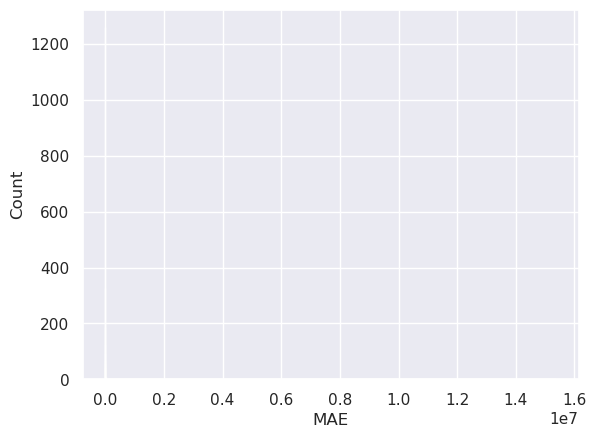

In [56]:
for metric in ['MAE','MSE','r2']:
    display(sns.histplot(data=dff, x=metric))

In [48]:
dff = df[df.r2 > -1.0]
dff_bad = df[df.r2 < -1.0]
len(df), len(dff), len(dff_bad)

(3130, 2846, 284)

In [50]:
dff.r2.hist

<bound method hist_series of 0       0.933
1       0.612
2       0.987
3       0.854
4       0.988
        ...  
3124    0.879
3125    0.958
3127   -0.080
3128   -0.045
3129    0.768
Name: r2, Length: 2846, dtype: float64>

{'Deaths_naive': {'MAE': 38.332043688633405,
  'MSE': 1646.6022241996295,
  'r2': -26930.355521230784,
  'relMAE': 1.0}}

In [29]:
# display(df.MAE.describe(),
# df.MSE.describe(),
# df.r2.describe())

# display(df.MAE.var(),
# df.MSE.var(),
# df.r2.var())